In [2]:
import uproot
import uproot_methods
import numpy as np
import pandas as pd

In [3]:
!which python

/home/newhouse/miniconda3/bin/python


In [29]:
f = uproot.open('/data/hnl/KShort/ntuples/dijet_mc16e/JZ8/user.rnewhous.23060122._000052.tree.root')
outTree = f['outTree']
df = outTree.pandas.df(flatten=False, entrystop=100)
outTree.keys()

/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


[b'runNumber',
 b'eventNumber',
 b'lumiBlock',
 b'coreFlags',
 b'bcid',
 b'mcEventNumber',
 b'mcChannelNumber',
 b'mcEventWeight',
 b'NPV',
 b'actualInteractionsPerCrossing',
 b'averageInteractionsPerCrossing',
 b'weight_pileup',
 b'correctedAverageMu',
 b'correctedAndScaledAverageMu',
 b'correctedActualMu',
 b'correctedAndScaledActualMu',
 b'rand_run_nr',
 b'rand_lumiblock_nr',
 b'pdgId1',
 b'pdgId2',
 b'pdfId1',
 b'pdfId2',
 b'x1',
 b'x2',
 b'q',
 b'xf1',
 b'xf2',
 b'weight',
 b'passesHnlMuMuFilter',
 b'passesHnlElMuFilter',
 b'passesHnlElElFilter',
 b'passesHnlMuElFilter',
 b'passesVH4bFilter',
 b'passL1',
 b'passHLT',
 b'passedTriggers',
 b'disabledTriggers',
 b'nmuon',
 b'muon_m',
 b'muon_pt',
 b'muon_phi',
 b'muon_eta',
 b'muon_charge',
 b'muon_isTrigMatched',
 b'muon_isTrigMatchedToChain',
 b'muon_listTrigChains',
 b'muon_isTight',
 b'muon_isMedium',
 b'muon_isLoose',
 b'muon_trkd0',
 b'muon_trkd0sig',
 b'muon_trkz0',
 b'muon_trkz0sintheta',
 b'muon_trkphi0',
 b'muon_trktheta',


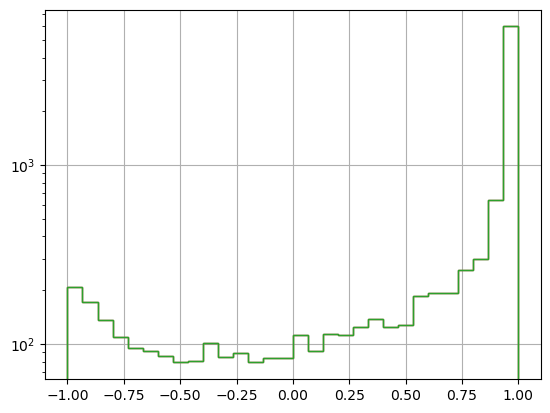

In [37]:
dff = outTree.pandas.df(['secVtx_VSI_LRTR3_1p0_maxOpAng', 'secVtx_VSI_LRTR3_1p0_minOpAng', 'secVtx_VSI_LRTR3_1p0_ntrk'])
dff = dff.query('secVtx_VSI_LRTR3_1p0_ntrk == 2')
(dff['secVtx_VSI_LRTR3_1p0_maxOpAng']).hist(bins=30, log=True, histtype='step')
(dff['secVtx_VSI_LRTR3_1p0_minOpAng']).hist(bins=30, log=True, histtype='step')
# import matplotlib.pyplot as plt
plt.show()

# Control Region
This is a mehod that calculates whether or not there is a prompt lepton in the event. This is the definition of our control region so we are not accidentally plotting potential signal regions.

In [38]:
def calc_pass_cr(row):
    '''To be used with df.apply()'''
    # Check muons
    for loose, medium, tight, d0, z0sintheta in zip(row['muon_isLoose'], 
                                                    row['muon_isMedium'], 
                                                    row['muon_isTight'],
                                                    row['muon_trkd0'],
                                                    row['muon_trkz0sintheta'],
                                   ):
        if loose or medium or tight:
            if abs(d0) < 3.0 or abs(z0sintheta) < 0.5: #mm
                return 0 # Found a prompt muon. Does not pass CR.
    # Check electrons
    for loose, medium, tight, d0, z0sintheta in zip(row['el_LHLoose'], 
                                                    row['el_LHMedium'], 
                                                    row['el_LHTight'],
                                                    row['el_trkd0'],
                                                    row['el_trkz0sintheta'],
                                   ):
        if loose or medium or tight:
            if abs(d0) < 3.0 or abs(z0sintheta) < 0.5: #mm
                return 0 # Found a prompt electron. Does not pass CR.
    return 1

# Alpha
This is the calculation of the parameter alpha, which is used to reduce the background when selecting k-short vertices.

In [39]:
def calc_alpha(row):
    '''To be used with df.apply()'''
    alphas = []
    
    if len(row['secVtx_VSI_LRTR3_1p0_x']) == 0:
        return alphas
    
    # primary vertex position vector
    pv_vector = uproot_methods.TVector3(row['vertex_x'],
                                        row['vertex_y'],
                                        row['vertex_z'])    

    for dv_x, dv_y, dv_z, dv_phi in zip(row['secVtx_VSI_LRTR3_1p0_x'], 
                                        row['secVtx_VSI_LRTR3_1p0_y'], 
                                        row['secVtx_VSI_LRTR3_1p0_z'],
                                        row['secVtx_VSI_LRTR3_1p0_phi'],
                                       ):

        # secondary vertex position vector
        sv_vector = uproot_methods.TVector3(dv_x,
                                            dv_y,
                                            dv_z)

        # vector from pv to sv
        pv_sv_vector = sv_vector - pv_vector

        # vector difference between momentum vector and position vector
        alpha = pv_sv_vector.phi - dv_phi
        # put in -pi to pi range
        alpha = (alpha + np.pi/2) % np.pi*2 - np.pi
        alphas.append(alpha)
    return alphas

# Iterating over a set of files
Using this method, we will iterate over several trees chained together across files. Uproot has some good documentation on how this works. https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-iterate

In [40]:
    
vertex_branches = ['secVtx_VSI_LRTR3_1p0_mass',
                    'secVtx_VSI_LRTR3_1p0_ntrk',
                    'secVtx_VSI_LRTR3_1p0_ntrk_lrt',
                    'secVtx_VSI_LRTR3_1p0_trk_isLRT',
                    'secVtx_VSI_LRTR3_1p0_r',
                    'secVtx_VSI_LRTR3_1p0_pt',
                    'secVtx_VSI_LRTR3_1p0_eta',
                    'secVtx_VSI_LRTR3_1p0_x',
                    'secVtx_VSI_LRTR3_1p0_y',
                    'secVtx_VSI_LRTR3_1p0_z',
                    'secVtx_VSI_LRTR3_1p0_phi',
                    'secVtx_VSI_LRTR3_1p0_maxOpAng'
                  ]

lepton_branches = ['muon_isTight',
                    'muon_isMedium',
                    'muon_isLoose',
                    'muon_trkd0',
                    'muon_trkz0sintheta',
                    'el_LHTight',
                    'el_LHMedium',
                    'el_LHLoose',
                    'el_trkd0',
                    'el_trkz0sintheta',]

pv_branches = ['vertex_x',
                'vertex_y',
                'vertex_z',]

branches = vertex_branches + lepton_branches + pv_branches

# remove duplicates
branches = list(dict.fromkeys(branches))


full_df = None

# for it in uproot.tree.iterate('/data/hnl/KShort/ntuples/dijet_mc16e/JZ8/*', 
for it in uproot.tree.iterate('/data/hnl/KShort/ntuples/dijet_mc16e/JZ12/*/submitDir/data-tree/files.root', 
                             'outTree',
                            branches=branches,
                            ):    

    # load chunk into dataframe
    df = pd.DataFrame(it)
    # remove bytesteam flag from columns
    df.columns = branches

    # calculate variables needed in selection
    
    # cut on control region
    df['pass_cr'] = df.apply(calc_pass_cr, axis=1)
    df = df.query('pass_cr > 0')
    # cut on number of DVs
    df = df[df['secVtx_VSI_LRTR3_1p0_mass'].str.len() > 1]
    # calculate alpha
    df['alpha'] = df.apply(calc_alpha, axis=1)
    
    # explode into a dataframe of just vertex quantities
    vtx_df = df[vertex_branches+['alpha']].apply(pd.Series.explode)
    
    # only use 2-trk vertices
    vtx_df = vtx_df.query('secVtx_VSI_LRTR3_1p0_ntrk == 2')
    
    # cut on alpha
    vtx_df = vtx_df[abs(vtx_df['alpha']) < 0.01]

    # append to the full dataframe
    if full_df is None:
        full_df = vtx_df
    else:
        full_df = full_df.append(vtx_df)
    print("Total vertices loaded:", len(full_df))
    
print("Finished")

/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 9


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 40


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 72


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 77


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 88


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 95


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 97


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 110


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 115


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 125


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 137


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 146


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 161


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 166


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 181


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 189


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 193


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 208


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 219


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 228


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 239


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 250


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 261


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 273


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 277


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 288


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 293


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 307


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 315


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 324


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 333


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 338


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 350


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 363


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 389


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 402


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 408


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 420


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 432


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 440


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 449


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 453


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 463


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 474


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 478


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 489


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 501


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 512


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 524


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 538


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 547


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 552


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 567


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 570


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 579


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 592


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 601


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 609


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 618


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 624


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 637


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 644


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 651


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 655


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 664


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 673


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 677


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 683


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 695


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 700


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 709


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 712


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 720


/home/newhouse/miniconda3/lib/python3.7/site-packages/awkward/array/base.py:394: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return cls.numpy.array(value, copy=False)


Total vertices loaded: 728
Finished


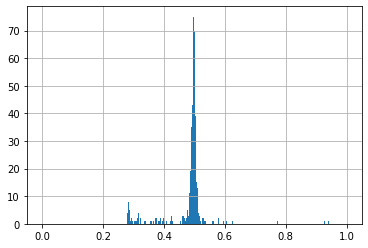

In [119]:
full_df.secVtx_VSI_LRTR3_1p0_mass.hist(bins=np.linspace(0,1,500))

In [8]:
# pd.read_pickle('/tmp/newhouse/jz12.pkl')


df = pd.concat([
    pd.read_pickle('/data/hnl/KShort/ntuples/dijet_mc16e/JZ12/output.pkl'),
    pd.read_pickle('/data/hnl/KShort/ntuples/dijet_mc16e/JZ11/output.pkl'),
    pd.read_pickle('/data/hnl/KShort/ntuples/dijet_mc16e/JZ10/output.pkl'),
    pd.read_pickle('/data/hnl/KShort/ntuples/dijet_mc16e/JZ8/output.pkl'),
    pd.read_pickle('/data/hnl/KShort/ntuples/dijet_mc16e/JZ9/output.pkl'),
])
    

<AxesSubplot:>

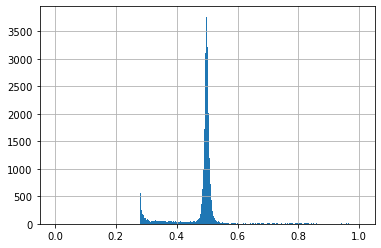

In [9]:
df.secVtx_VSI_LRTR3_1p0_mass.hist(bins=np.linspace(0,1,1000))

### Small snippet for merging multiple output MC files

In [4]:
import glob
import pandas as pd
jzslice = 'JZ2'
df = pd.concat([pd.read_pickle(path) for path in glob.glob(f'/data/hnl/KShort/ntuples/dijet_mc16e/{jzslice}_selected/*.pkl')])
df.to_pickle(f'/data/hnl/KShort/ntuples/dijet_mc16e/{jzslice}/output.pkl')



<AxesSubplot:>

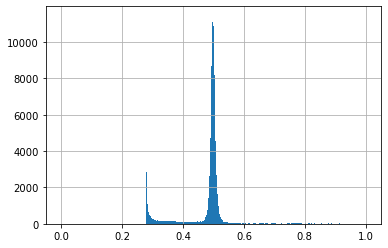

In [25]:
df.secVtx_VSI_LRTR3_1p0_mass.hist(bins=np.linspace(0,1,1000))